# K-Means Clustering
This notebook will use an unsupervised learning technique known as $k$-means clustering. First, import all the libraries:

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from matplotlib.gridspec import GridSpec
from skimage.color import rgb2gray
from skimage.filters import sobel

Next, we reduce each image tile $\mathbf{I}_i \in \mathbb{R}^{3 \times H \times W}$ to a compact numerical representation. This process should allow $k$-means to easily cluster the data based on certain visual aspects of the tile. For example, urban tiles are more noisy due to the number of structures. Uninhabited deserts should look smooth and homogeneous. For each $band \in \{\text{red, green, blue}\}$, define the following statistics over all pixels $(x,y)$ in the band:

$$
\mu_{i,band} = \frac{1}{HW} \sum_{y=0}^{H-1} \sum_{x=0}^{W-1} \mathbf{I}_i [band][x][y],
$$

$$
\sigma_{i,band} = \sqrt{\frac{1}{HW} \sum_{y=0}^{H-1} \sum_{x=0}^{W-1} (\mathbf{I}_i [band][x][y] - \mu_{i, band})^2},
$$

$$
P^{(10)}_{i,band} = \text{10}^\text{th} \text{ percentile of } \mathbf{I}_i[band], \quad
P^{(50)}_{i,band} = \text{50}^\text{th} \text{ percentile of } \mathbf{I}_i[band], \quad
P^{(90)}_{i,band} = \text{90}^\text{th} \text{ percentile of } \mathbf{I}_i[band].
$$

where $0 \leq i \leq 30443$ and $H$ is the height and $W$ is the width in pixels. To capture intra-tile heterogeneity, we convert the tile to grayscale:

$$
\mathbf{I}_{i, \text{gray}} = 0.2989 \, \mathbf{I}_i[\text{red}] + 0.5870 \, \mathbf{I}_i[\text{green}] + 0.1140 \, \mathbf{I}_i[\text{blue}].
$$

These coefficients are derived from the **ITU-R BT.601 (Rec. 601)** standard, which defines how to convert RGB (in the sRGB color space) to luma, i.e., perceived brightness. We then can compute a noise statistic based on the gradient magnitude using the Sobel operator:

$$
\frac{\partial \mathbf{I}_{i, \text{gray}}}{\partial x}, \frac{\partial \mathbf{I}_{i, \text{gray}}}{\partial y} = \text{Sobel}(\mathbf{I}_{i, \text{gray}}), \quad
|\nabla \mathbf{I}_{i, \text{gray}}| = \sqrt{\left(\frac{\partial \mathbf{I}_{i, \text{gray}}}{\partial x}\right)^2 + \left(\frac{\partial \mathbf{I}_{i, \text{gray}}}{\partial y}\right)^2},
$$

$$
\mu_{i,\text{noise}} = \frac{1}{HW} \sum_{y=0}^{H-1} \sum_{x=0}^{W-1} |\nabla \mathbf{I}_{i, \text{gray}}(x,y)|,
$$$$
\sigma_{i,\text{noise}} = \sqrt{\frac{1}{HW} \sum_{y=0}^{H-1} \sum_{x=0}^{W-1} (|\nabla \mathbf{I}_{i, \text{gray}}(x,y)| - \mu_{i,\text{noise}})^2}.
$$

Finally, we can capture local heterogeneity by dividing the grayscale image into $n \times n$ patches $\{P_k\}_{k=1}^{n^2}$, and computing the variance within each patch:

$$
\mu_{i,\text{patch}} = \frac{1}{n^2} \sum_{k=1}^{n^2} \text{Var}(P_k),
$$$$
\sigma_{i,\text{patch}} = \sqrt{\frac{1}{n^2} \sum_{k=1}^{n^2} (\text{Var}(P_k) - \mu_{i,\text{patch}})^2}.
$$

The final feature vector combines all of these statistics:

$$
\vec{x_i} = \begin{bmatrix} \mu_{i, \text{red}} & \sigma_{i, \text{red}} & P^{(10)}_{i,\text{red}} & \cdots & \mu_{i, \text{green}} & \sigma_{i, \text{green}} & P^{(10)}_{i,\text{green}} & \cdots & \mu_{i, \text{blue}} & \sigma_{i, \text{blue}} & P^{(10)}_{i,\text{blue}} & \cdots & \mu_{i,\text{noise}} & \sigma_{i,\text{noise}} & \mu_{i,\text{patch}} & \sigma_{i,\text{patch}} \end{bmatrix} \in \mathbb{R}^{1 \times 19}.
$$

In [2]:
def extract_features(tif_path, n_patches=4):
    with rasterio.open(tif_path) as src:
        img = src.read() # shape: B x H x W
        B, H, W = img.shape
        img = img.astype(np.float32)
        img /= np.percentile(img, 99) # normalize
        img = np.clip(img, 0, 1)
        img = img.transpose(1, 2, 0)
        features = []
        
        for b in range(B):
            band = img[:, :, b]
            mu = np.mean(band)
            sigma = np.std(band)
            p10 = np.percentile(band, 10)
            p50 = np.percentile(band, 50)
            p90 = np.percentile(band, 90)
            features.extend([mu, sigma, p10, p50, p90])
        
        gray = rgb2gray(img)
        grad_mag = sobel(gray)
        features.append(grad_mag.mean())
        features.append(grad_mag.std())
        patch_h, patch_w = H // n_patches, W // n_patches
        patch_vars = []
        
        for i in range(n_patches):
            for j in range(n_patches):
                patch = gray[i*patch_h:(i+1)*patch_h, j*patch_w:(j+1)*patch_w]
                patch_vars.append(patch.var())
                
        features.append(np.mean(patch_vars))
        features.append(np.std(patch_vars))
        
    return np.array(features)

Stacking each $\vec{x_i}$, we get the feature matrix

$$
\mathbf{X} = \begin{bmatrix}
    \vec{x_0} \\
    \vec{x_1} \\
    \cdots \\
    \vec{x}_{30443}
\end{bmatrix} \in \mathbb{R}^{30444 \times 19}.
$$

In [3]:
X = np.zeros((30444, 19)) 
for i in tqdm(range(30444)):
    X[i] = extract_features(f"HLS2-s30_rgb/tile{i}.tif")

100%|████████████████████████████████████████████████████████████████████████| 30444/30444 [14:52<00:00, 34.10it/s]


K-means minimizes the within-cluster sum of squares (WCSS):

$$
\min_{\{C_k\}^K_{k=1}} \sum_{k=1}^{K} \sum_{x_i \in C_k} \sum_{j=1}^{19} (x_{ij} - \mu_{kj})^2,
$$

where $K$ is the number of clusters, $\mu_{k} \in \mathbb{R}^{19}$ is the centroid of the cluster, define as:

$$
\mu_{k} = \frac{1}{|C_k|} \sum_{x_i \in C_k} x_i.
$$

This process is repeated until centroids converge or assignments stop changing. This assumes all the features are normalized, which we will accomplish in this step:

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.82917829,  0.77349448, -1.21621955, ...,  2.08602636,
         1.58390945,  0.57468908],
       [-0.55876542,  1.05328629, -0.50575027, ...,  1.9044237 ,
         1.7695743 ,  0.99747675],
       [-0.59953204,  0.66051891, -0.31816875, ...,  1.84404626,
         1.32288533,  0.94658331],
       ...,
       [-0.24086968,  1.39650945, -1.21621955, ...,  0.23071905,
         0.44184521, -0.0183667 ],
       [-0.69126466,  1.15154474, -1.21621955, ...,  0.25015374,
         0.30387278, -0.04678445],
       [-0.82966652,  1.17381538, -1.21621955, ...,  0.36768663,
        -0.09982579, -0.02650287]], shape=(30444, 19))

We now want to determine the optimal number of clusters. This is done by finding a $K$ such that maximum curvature is obtained on the elbow plot. Let $\text{WCSS}(K) : \mathbb{N} \rightarrow \mathbb{R}$ return the within-cluster sum of squares for a particular $K$. Then, the formal objective is

$$
K^* = \arg \max_K \bigg(\frac{|\text{WCSS}''(K)|}{\sqrt{(1 + \text{WCSS}'(K)^2)^3}} \bigg).
$$

$K^*$ will now have the optimal curvature. We will now use this method to attempt to find $K^*$:

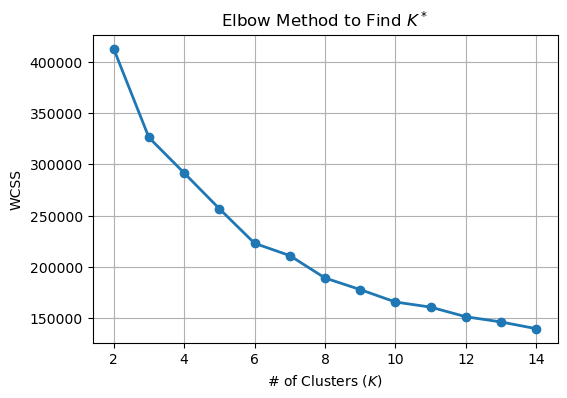

In [5]:
inertias = []
Ks = range(2, 15)

for K in Ks:
    kmeans = KMeans(n_clusters=K)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, 'o-', linewidth=2)
plt.xlabel("# of Clusters ($K$)")
plt.ylabel("WCSS")
plt.title("Elbow Method to Find $K^*$")
plt.grid(True)
plt.show()

Qualitatively analyzing the elbow plot above, we see that at no point does the curvature reach a significant value. We can still try to determine $K^*$ analytically, but it will be not that useful as it will be a very small value ($\text{WCSS}(K^*) \approx 10^{-9}$). In short, a smooth exponential-looking elbow plot tells us the data lacks sharp natural clusters, which is to be expected of fairly homogeneous satellite imagery. Going forwards, let us try again but this time we use the highest silhouette score instead:

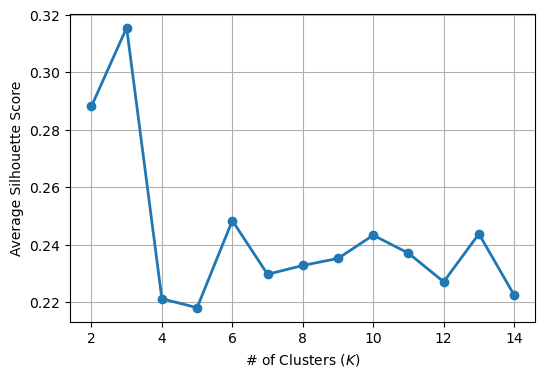

In [6]:
sil_scores = []
for K in Ks:
    kmeans = KMeans(n_clusters=K)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

plt.figure(figsize=(6,4))
plt.plot(Ks, sil_scores, 'o-', linewidth=2)
plt.xlabel("# of Clusters ($K$)")
plt.ylabel("Average Silhouette Score")
plt.grid(True)
plt.show()

Looking at the plot above, there is a clear value of $K = 3$ giving us the highest mean silhouette score. This means having three clusters gives us the best chance. Based on the results, this score tells us that the clusters are reasonably separated, but there is some overlap, which is not excellent, but typical for real-world, noisy, high-dimensional data like satellite tiles. Now we will choose some sample tiles from each cluster to visualize the distinction between each cluster:

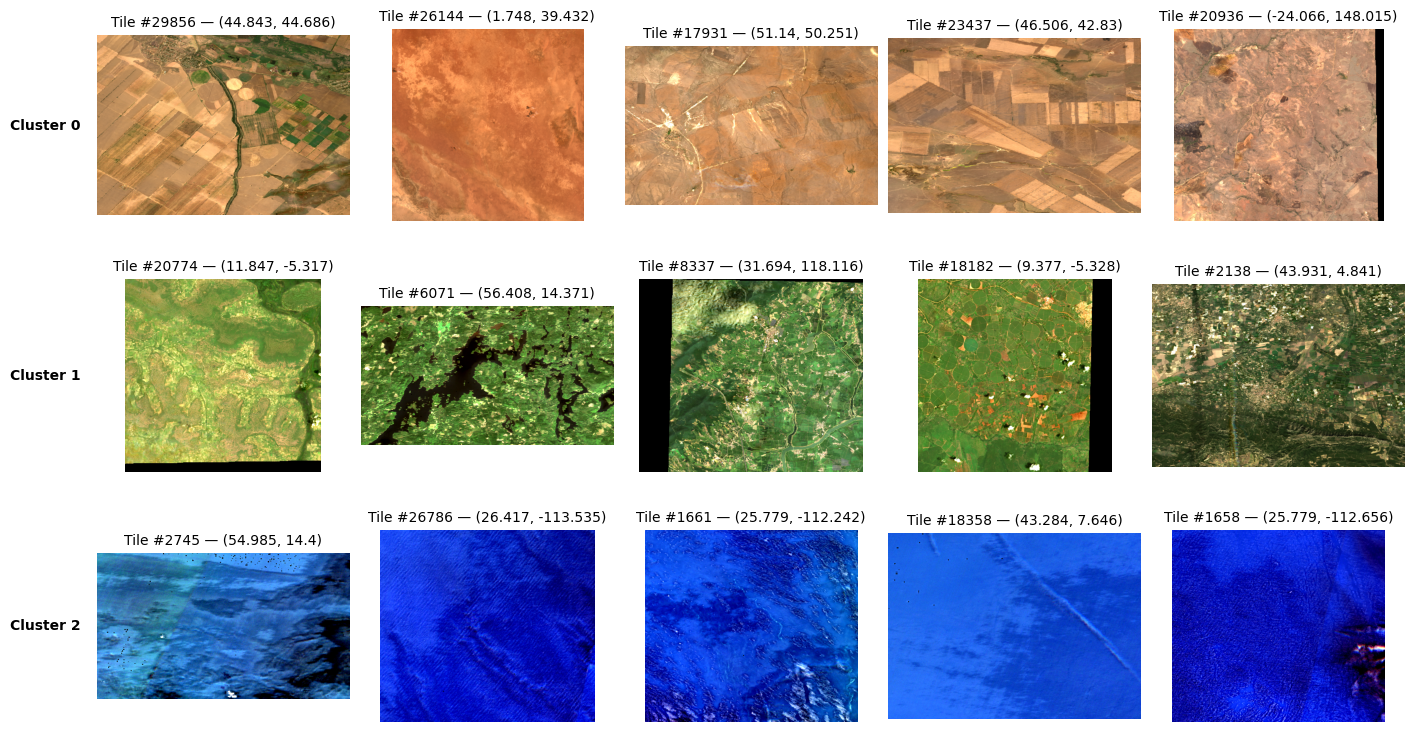

In [68]:
K = 3
k_means = KMeans(n_clusters=K)
k_means.fit(X_scaled)
tiles_per_cluster = 5
fig = plt.figure(figsize=((tiles_per_cluster+1)*3, K*3))
gs = GridSpec(K, tiles_per_cluster + 1, figure=fig, width_ratios=[0.3] + [1]*tiles_per_cluster, wspace=0.05, hspace=0.3)

for k in range(K):
    cluster_indices = np.where(k_means.labels_ == k)[0]
    sample_indices = np.random.choice(cluster_indices, size=tiles_per_cluster, replace=False)
    ax_label = fig.add_subplot(gs[k, 0])
    ax_label.text(0, 0.5, f"Cluster {k}", fontsize=10, fontweight='bold', ha='left', va='center')
    ax_label.axis('off')
    
    for j, idx in enumerate(sample_indices):
        tile_path = f"HLS2-s30_rgb/tile{idx}.tif"
        with rasterio.open(tile_path) as src:
            img = src.read([1, 2, 3]).astype(np.float32)
            img /= np.percentile(img, 99)
            img = np.clip(img, 0, 1)
            img = img.transpose(1, 2, 0)
            height, width = img.shape[0], img.shape[1]
            center_x, center_y = src.transform * (width // 2, height // 2)
            center_x = round(center_x, 3)
            center_y = round(center_y, 3)
        
        ax_img = fig.add_subplot(gs[k, j+1])
        ax_img.imshow(img)
        ax_img.axis('off')
        ax_img.set_title(f"Tile #{idx} — ({center_y}, {center_x})", fontsize=10)

plt.show()